In [1]:
from torch_geometric.graphgym import GCNConv
%load_ext autoreload
%autoreload 2

/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/torch_geometric/graphgym/config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/torch_geometric/graphgym/imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [2]:
import numpy as np
import torch
from torch_geometric.data import Data

In [3]:
from nilearn import datasets

abide = datasets.fetch_abide_pcp(
    data_dir="/Users/balazsmorvay/Downloads/nilearn_data",
    derivatives="rois_cc200",
    pipeline="cpac",
    band_pass_filtering=True,
    global_signal_regression=True,
    quality_checked=True,
)

[fetch_abide_pcp] Dataset found in /Users/balazsmorvay/Downloads/nilearn_data/ABIDE_pcp


In [4]:
def corr_fisher_z(X):  # X: (T, N) ROI time-series
    C = np.corrcoef(X, rowvar=False)          # (N, N)
    C = np.clip(C, -0.999999, 0.999999)
    Z = np.arctanh(C)                         # Fisher z
    np.fill_diagonal(Z, 0.0)
    return Z

def make_node_features(Z, mode='corr_row'):
    """
    'corr_row' -> node i feature = i-th row of Z (NeuroGraph style)
    'none'     -> no explicit node features (ones)
    """
    N = Z.shape[0]
    if mode == 'corr_row':
        X = Z.copy()
        np.fill_diagonal(X, 0.0)
        return X
    return np.ones((N, 1), dtype=float)

def to_pyg(A, X, y=None, meta=None):
    if Data is None:
        return dict(edge_index=None, edge_weight=None, x=X, y=y, meta=meta)
    # build edge_index/weight from upper triangle
    i, j = np.where(np.triu(A, 1) > 0)
    w = A[i, j]
    # make undirected (i<->j)
    ei = np.vstack([np.hstack([i, j]), np.hstack([j, i])])
    ew = np.hstack([w, w]).astype(np.float32)
    x = torch.tensor(X, dtype=torch.float32)
    data = Data(x=x, # Node features
                edge_index=torch.tensor(ei, dtype=torch.long),
                edge_weight=torch.tensor(ew),
                y=None if y is None else torch.tensor([y], dtype=torch.long))
    data.meta = meta
    return data

In [5]:
graphs = []
normalized_node_features = []
for i, ts in enumerate(abide.rois_cc200):
    pheno = abide.phenotypic.iloc[i]
    # 3.1 connectivity (Fisher-z of Pearson corr)
    Z = corr_fisher_z(ts)
    # 3.2 sparsify like NeuroGraph (e.g., top 10% positive edges)
    # A = top_p_sparsify(Z, p=0.10, keep_positive=True)
    # 3.3 node features (corr row vectors)
    X = make_node_features(Z, mode='corr_row')

    # Similarity matrix -> Distance matrix
    max_dist = np.nanmax(X)
    X = max_dist - X
    np.fill_diagonal(X, 0.0)
    if np.isnan(X.max()):
        X[np.isnan(X)] = max_dist * 1.01
        print(f"nan in {i}")


    normalized_node_features.append(X)
    # 3.4 label: ASD(1)/HC(2) in ABIDE PCP; convert to 0/1
    dx = pheno.get('DX_GROUP')
    y = None if dx is None else int(dx == 1)  # 1=ASD -> 1, 2=HC -> 0
    # 3.5 site/domain
    site = pheno.get('SITE_ID', pheno.get('SITE_NAME', 'NA'))
    graphs.append(to_pyg(Z, X, y=y, meta={'site': site, 'age': pheno.get('AGE_AT_SCAN')}))

print(f'Built {len(graphs)} graphs (static). Example meta:', graphs[0].meta if graphs else None)

nan in 36
nan in 105
nan in 113
nan in 125


/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan in 149
nan in 150
nan in 392
nan in 394
nan in 401
nan in 589
nan in 641
nan in 830
nan in 832
nan in 838
nan in 845
Built 871 graphs (static). Example meta: {'site': 'PITT', 'age': np.float64(24.45)}


In [6]:
len(graphs), graphs[33]

(871,
 Data(
   x=[200, 200],
   edge_index=[2, 18630],
   y=[1],
   edge_weight=[18630],
   meta={
     site='PITT',
     age=33.17,
   }
 ))

In [7]:
nyu_sites = {'NYU'}
um_sites = {'UM_1', 'UM_2'}
usm_sites = {'USM'}
ucla_sites = {'UCLA_1', 'UCLA_2'}
leuven_sites = {'LEUVEN_1', 'LEUVEN_2'}

nyu_graphs = []
um_graphs = []
usm_graphs = []
ucla_graphs = []
leuven_graphs = []

for graph in graphs:
    site = graph.meta.get('site')
    if site in nyu_sites:
        nyu_graphs.append(graph)
    elif site in um_sites:
        um_graphs.append(graph)
    elif site in usm_sites:
        usm_graphs.append(graph)
    elif site in ucla_sites:
        ucla_graphs.append(graph)
    elif site in leuven_sites:
        leuven_graphs.append(graph)

# (Optional) Print the number of graphs in each new list to verify
print(f"Graphs from NYU: {len(nyu_graphs)}")
print(f"Graphs from UM_1 & UM_2: {len(um_graphs)}")
print(f"Graphs from USM: {len(usm_graphs)}")
print(f"Graphs from UCLA_1 & UCLA_2: {len(ucla_graphs)}")
print(f"Graphs from Leuven_1 & Leuven_2: {len(leuven_graphs)}")

Graphs from NYU: 172
Graphs from UM_1 & UM_2: 120
Graphs from USM: 67
Graphs from UCLA_1 & UCLA_2: 85
Graphs from Leuven_1 & Leuven_2: 56


# Adaptation

In [8]:
from FGWDomainAdaptation import FGWDomainAdaptation

adapt = FGWDomainAdaptation(Xs=leuven_graphs, Xt=usm_graphs)

In [9]:
adapt.compute_distances()

1/3752
2/3752
3/3752
4/3752
5/3752
6/3752
7/3752
8/3752
9/3752
10/3752
11/3752
12/3752
13/3752
14/3752
15/3752
16/3752
17/3752
18/3752
19/3752
20/3752
21/3752
22/3752
23/3752
24/3752
25/3752
26/3752
27/3752
28/3752
29/3752
30/3752
31/3752
32/3752
33/3752
34/3752
35/3752
36/3752
37/3752
38/3752
39/3752
40/3752
41/3752
42/3752
43/3752
44/3752
45/3752
46/3752
47/3752
48/3752
49/3752
50/3752
51/3752
52/3752
53/3752
54/3752
55/3752
56/3752
57/3752
58/3752
59/3752
60/3752
61/3752
62/3752
63/3752
64/3752
65/3752
66/3752
67/3752
68/3752
69/3752
70/3752
71/3752
72/3752
73/3752
74/3752
75/3752
76/3752
77/3752
78/3752
79/3752
80/3752
81/3752
82/3752
83/3752
84/3752
85/3752
86/3752
87/3752
88/3752
89/3752
90/3752
91/3752
92/3752
93/3752
94/3752
95/3752
96/3752
97/3752
98/3752
99/3752
100/3752
101/3752
102/3752
103/3752
104/3752
105/3752
106/3752
107/3752
108/3752
109/3752
110/3752
111/3752
112/3752
113/3752
114/3752
115/3752
116/3752
117/3752
118/3752
119/3752
120/3752
121/3752
122/3752
123/3752
1

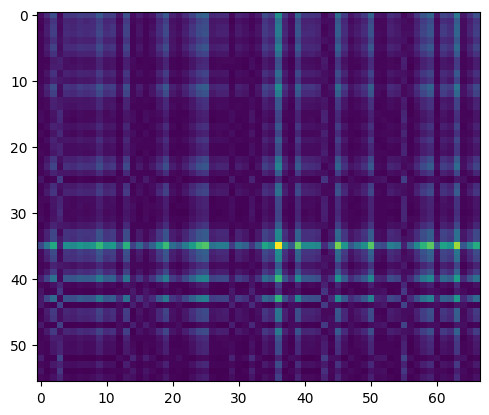

In [10]:
import matplotlib.pyplot as plt

plt.imshow(adapt.cost_matrix)

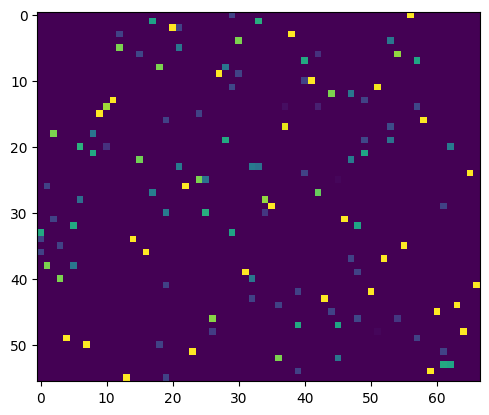

In [11]:
import matplotlib.pyplot as plt

plt.imshow(adapt.P)

In [12]:
transp_Xt = adapt.transport()

[29, 56]
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.608365e+00|0.000000e+00|0.000000e+00
    1|2.601453e+00|2.657249e-03|6.912708e-03
    2|2.589034e+00|4.796765e-03|1.241899e-02
    3|2.579737e+00|3.603815e-03|9.296894e-03
    4|2.577462e+00|8.823697e-04|2.274275e-03
    5|2.576831e+00|2.450034e-04|6.313324e-04
    6|2.576669e+00|6.282770e-05|1.618862e-04
    7|2.576617e+00|2.044950e-05|5.269051e-05
    8|2.576611e+00|2.220765e-06|5.722046e-06
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.152913e+00|0.000000e+00|0.000000e+00
    1|2.143883e+00|4.211809e-03|9.029627e-03
    2|2.135220e+00|4.057276e-03|8.663177e-03
    3|2.128387e+00|3.210448e-03|6.833076e-03
    4|2.124981e+00|1.602860e-03|3.406048e-03
    5|2.123032e+00|9.182853e-04|1.949549e-03
    6|2.122217e+00|3.836550e-04|8.141994e-04
    7|2.121925e+00|1.377528e-04|2.923012e-04
    8|2.121811e+00|5.359839e-05|1.

In [13]:
yt = [g.y for g in leuven_graphs]
yt

[tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1])]

# Create the datasets

In [14]:
transp_Xt

[tensor([[0.0000, 1.9269, 1.6344,  ..., 1.5813, 1.3762, 1.7535],
         [1.9269, 0.0000, 1.8632,  ..., 1.3197, 1.7755, 1.6470],
         [1.6344, 1.8632, 0.0000,  ..., 1.8746, 1.4886, 1.9185],
         ...,
         [1.5813, 1.3197, 1.8746,  ..., 0.0000, 1.7905, 1.6691],
         [1.3762, 1.7755, 1.4886,  ..., 1.7905, 0.0000, 1.3905],
         [1.7535, 1.6470, 1.9185,  ..., 1.6691, 1.3905, 0.0000]]),
 tensor([[0.0000, 1.2577, 1.4018,  ..., 1.3517, 1.4065, 1.3172],
         [1.2577, 0.0000, 1.8859,  ..., 1.1477, 1.5020, 1.2857],
         [1.4018, 1.8859, 0.0000,  ..., 1.7968, 1.5084, 1.5376],
         ...,
         [1.3517, 1.1477, 1.7968,  ..., 0.0000, 1.5256, 1.3763],
         [1.4065, 1.5020, 1.5084,  ..., 1.5256, 0.0000, 1.4929],
         [1.3172, 1.2857, 1.5376,  ..., 1.3763, 1.4929, 0.0000]]),
 tensor([[0.0000, 1.6071, 1.4769,  ..., 1.6034, 1.5854, 1.4635],
         [1.6071, 0.0000, 1.0173,  ..., 1.5248, 1.7043, 1.0203],
         [1.4769, 1.0173, 0.0000,  ..., 1.2356, 1.7070, 0.

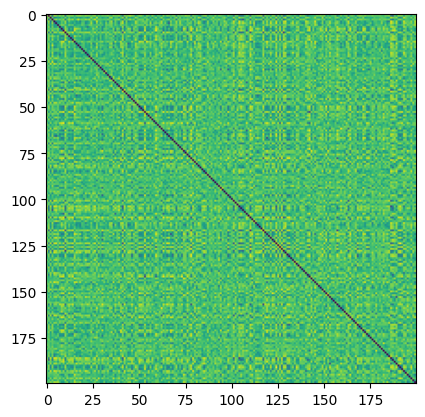

In [22]:
plt.imshow(transp_Xt[0])

In [15]:
train_graphs = []
print("Preparing training data from 'transp_Xt'...")
for i, adj_matrix_np in enumerate(transp_Xt):
    X = adj_matrix_np.copy()
    max_dist = np.nanmax(X)
    X = max_dist - X
    np.fill_diagonal(X, 0.0)
    if np.isnan(X.max()):
        X[np.isnan(X)] = max_dist * 1.01

    # b) Create Graph Structure (edge_index and edge_weight)
    # We build the graph structure from all positive connections in the transported matrix
    rows, cols = np.where(np.triu(adj_matrix_np, 1) > 0)
    edge_index_np = np.vstack([np.hstack([rows, cols]), np.hstack([cols, rows])])
    edge_weight_np = np.hstack([adj_matrix_np[rows, cols], adj_matrix_np[cols, rows]])

    # c) Create the PyG Data object
    data = Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=torch.tensor(edge_index_np, dtype=torch.long),
        edge_weight=torch.tensor(edge_weight_np, dtype=torch.float32),
        y=torch.tensor([train_labels[i]], dtype=torch.long)
    )
    train_graphs.append(data)

print(f"Successfully created {len(train_graphs)} training graphs.")

Preparing training data from 'transp_Xt'...


AttributeError: 'Tensor' object has no attribute 'copy'

# Classify

In [ ]:
from GNN import ResidualGNNs
from types import SimpleNamespace

args = SimpleNamespace(
    model="GCN",
    num_classes=2
)



model = ResidualGNNs(args=args, train_dataset=, hidden_channels=, hidden=, num_layers=, GNN=GCNConv, k=0.6)